In [17]:
pip install tidytext textblob

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 8.4 MB/s eta 0:00:0000:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
# from xgboost import XGBClassifier

from Help_Funs import count_chars, count_words, count_capital_chars, count_capital_words, count_sent, count_unique_words, count_stopwords, count_hashtags 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Covid-tweets/training_data.csv'
file_key_2 = 'Covid-tweets/test_data.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)

## Feature Engineering 
train['is_quote'] = train['is_quote'].str.lower()
train['is_quote'] = np.where(train['is_quote'] == 'false', 0, 1)
train['is_retweet'] = train['is_retweet'].str.lower()
train['is_retweet'] = np.where(train['is_retweet'] == 'false', 0, 1)
train['Trump_flag'] = np.where(train['reply_to_screen_name'] == 'realDonaldTrump', 1, 0)
train['jfrketich_flag'] = np.where(train['reply_to_screen_name'] == 'jfrketich', 1, 0)


test['is_quote'] = np.where(test['is_quote'] == False, 0, 1)
test['is_retweet'] = np.where(test['is_retweet'] == False, 0, 1)
test['Trump_flag'] = np.where(test['reply_to_screen_name'] == 'realDonaldTrump', 1, 0)
test['jfrketich_flag'] = np.where(test['reply_to_screen_name'] == 'jfrketich', 1, 0)

In [13]:
## Defining stopwords
stop_words = set(stopwords.words('english'))
others = set(["1", "2", "it'll", "ill", "=", '+', "'s'", '"'])
stop_words = stop_words.union(others)

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    temp = " ".join(word for word in temp)
    return temp

In [14]:
train['clean_tweet'] = np.nan

for i in tqdm(range(0, train.shape[0])):
    
    train['clean_tweet'][i] =  clean_tweet(train['text'][i])

  0%|          | 0/240000 [00:00<?, ?it/s]/tmp/ipykernel_8449/4248643825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['clean_tweet'][i] =  clean_tweet(train['text'][i])
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 240000/240000 [00:08<00:00, 27094.70it/s]


In [15]:
train.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country,Trump_flag,jfrketich_flag,clean_tweet
0,Remember the #WuhanCoronaVirus? The pandemic w...,NaN,1,1,WuhanCoronaVirus KillerCuomo,us,0,0,remember pandemic great percentage deaths resu...
1,My sources @WhiteHouse say 2 tactics will be u...,NaN,1,1,Trump,us,0,0,sources say tactics used get america open amp ...
2,I'll venture a wild guess: If you were running...,NaN,1,1,COVID19,us,0,0,venture wild guess running usa crisis youd wan...
3,#Pakistan (#GreenStimulus = #Nature protection...,NaN,1,1,Pakistan GreenStimulus Nature Green,us,0,0,protection jobs community youth within recentl...
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,NaN,1,1,coronavirus COVID__19 COVIDー19,us,0,0,pand mie de 30 pasteurs ricains qui avaient mi...


In [20]:
from textblob import TextBlob

train['sentiment'] = train['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [21]:
train.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country,Trump_flag,jfrketich_flag,clean_tweet,sentiment
0,Remember the #WuhanCoronaVirus? The pandemic w...,NaN,1,1,WuhanCoronaVirus KillerCuomo,us,0,0,remember pandemic great percentage deaths resu...,0.20000
1,My sources @WhiteHouse say 2 tactics will be u...,NaN,1,1,Trump,us,0,0,sources say tactics used get america open amp ...,0.00000
2,I'll venture a wild guess: If you were running...,NaN,1,1,COVID19,us,0,0,venture wild guess running usa crisis youd wan...,0.22500
3,#Pakistan (#GreenStimulus = #Nature protection...,NaN,1,1,Pakistan GreenStimulus Nature Green,us,0,0,protection jobs community youth within recentl...,0.03125
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,NaN,1,1,coronavirus COVID__19 COVIDー19,us,0,0,pand mie de 30 pasteurs ricains qui avaient mi...,0.00000


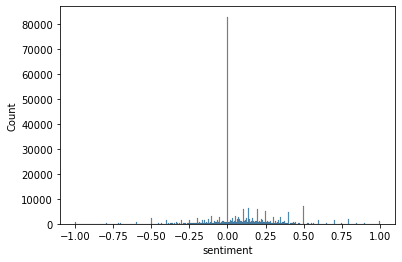

In [23]:
sns.histplot(x = 'sentiment', data = train)
plt.show();

In [189]:
train.loc[4]

text                    🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...
reply_to_screen_name                                                  NaN
is_quote                                                                1
is_retweet                                                              1
hashtags                                   coronavirus COVID__19 COVIDー19
country                                                                us
Trump_flag                                                              0
jfrketich_flag                                                          0
Name: 4, dtype: object

In [48]:
from tidytext import unnest_tokens
import re

A = pd.DataFrame({'text': train['text']})
A.head()

,text
0,Remember the #WuhanCoronaVirus? The pandemic w...
1,My sources @WhiteHouse say 2 tactics will be u...
2,I'll venture a wild guess: If you were running...
3,#Pakistan (#GreenStimulus = #Nature protection...
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...


In [227]:
re.sub('[^a-zA-Z]', ' ', test[0])

KeyError: 0

In [290]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

test_str = A['text'][543]
print(test_str)

for ele in test_str:
    if ele in punc:
        test_str = test_str.replace(ele, '')
        
print(test_str)        

@JoeBiden - This is #Chinese #Propaganda &amp; not true!

To refresh ur Dementia Mind, #China LIED, the @WHO LIED &amp; #DrFauci said in January, #USA has nothing to fear with #COVID19! THEN @POTUS finds out it DOES transfer Human-to-Human &amp; immediately BANNED Flights from China Jan. 28!
JoeBiden  This is Chinese Propaganda amp not true

To refresh ur Dementia Mind China LIED the WHO LIED amp DrFauci said in January USA has nothing to fear with COVID19 THEN POTUS finds out it DOES transfer HumantoHuman amp immediately BANNED Flights from China Jan 28


In [291]:
test_str = re.sub(r'http\S+', '', test_str)
print(test_str)

JoeBiden  This is Chinese Propaganda amp not true

To refresh ur Dementia Mind China LIED the WHO LIED amp DrFauci said in January USA has nothing to fear with COVID19 THEN POTUS finds out it DOES transfer HumantoHuman amp immediately BANNED Flights from China Jan 28


In [292]:
list1 = [test_str]
rez = []

for x in list1:
    rez.append(x.replace('-', ' '))

print("New list : " + str(rez))

New list : ['JoeBiden  This is Chinese Propaganda amp not true\n\nTo refresh ur Dementia Mind China LIED the WHO LIED amp DrFauci said in January USA has nothing to fear with COVID19 THEN POTUS finds out it DOES transfer HumantoHuman amp immediately BANNED Flights from China Jan 28']


In [282]:
list1 = [test_str]
rez = []

for x in list1:
    rez.append(x.replace('\n', ' '))

print("New list : " + str(rez))

New list : ['So I made a memecorona virus meme coronavirusmeme toilet paper coronapocalypse ']


In [283]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
example_sent = rez
  
stop_words = set(stopwords.words('english'))
others = set(["1", "2", "it'll", "ill", "=", '+', "'s'", '"'])
stop_words = stop_words.union(others)
  
word_tokens = word_tokenize(example_sent[0])
  
filtered_sentence = ' '.join([w for w in word_tokens if not w.lower() in stop_words])
filtered_sentence

'made memecorona virus meme coronavirusmeme toilet paper coronapocalypse'

In [272]:
import numpy as np
import re

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
#     word_tokens = word_tokenize(temp)
    temp = [w for w in temp if not w in stop_words]
    temp = " ".join(word for word in temp)
    return temp

In [293]:
x = clean_tweet(A['text'][1020])
x
# [w for w in x if not w in stop_words]

'nothing important safety children middle crisis ensure america children safe actionable plan magical thinking'

In [136]:
a = filtered_sentence.replace(" ' ", "")
a

'Remember WuhanCoronaVirus pandemic great percentage deaths resulted KillerCuomo ’ nursing home slaughter one quarantined Democrats ’ back rest assured soon riots stop Anything destroy Trump'

In [118]:
for ele in filtered_sentence:
    if ele in "\'":
        filtered_sentence = filtered_sentence.replace(ele, '')

In [119]:
filtered_sentence

'Remember WuhanCoronaVirus pandemic great percentage deaths resulted KillerCuomo ’ nursing home slaughter one quarantined Democrats ’ back rest assured soon riots stop Anything destroy Trump'

In [96]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [17]:
B = unnest_tokens(A, 'word', 'text')

In [19]:
B.shape

(6997814, 1)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
analyze = vectorizer.build_analyzer()

In [24]:
analyze(A['text'][0])

['remember',
 'the',
 'wuhancoronavirus',
 'the',
 'pandemic',
 'where',
 'great',
 'percentage',
 'of',
 'the',
 'deaths',
 'resulted',
 'from',
 'killercuomo',
 'nursing',
 'home',
 'slaughter',
 'the',
 'one',
 'where',
 'we',
 'were',
 'quarantined',
 'by',
 'democrats',
 'it',
 'll',
 'be',
 'back',
 'rest',
 'assured',
 'as',
 'soon',
 'as',
 'the',
 'riots',
 'stop',
 'anything',
 'to',
 'destroy',
 'trump']

In [26]:
Doc = [A['text'][0], A['text'][1], A['text'][2]]
X = vectorizer.fit_transform(Doc)

In [29]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.278771,0.139386,0.139386,0.106006,0.000000,0.139386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.139386,0.000000,0.139386,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.000000,0.139386,0.000000,0.000000,0.139386,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.000000,0.139386,0.000000,0.106006,0.000000,...,0.106006,0.000000,0.139386,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.139386,0.000000,0.139386,0.000000,0.139386,0.139386,0.139386,0.139386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.139386,0.000000,0.139386,0.000000,0.530031,0.000000,0.000000,0.082323,0.082323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.106006,0.278771,0.000000,0.000000,0.000000,0.000000,0.139386,0.000000,0.000000
1,0.000000,0.000000,0.108790,0.143046,0.143046,0.326370,0.143046,0.000000,0.000000,0.000000,0.000000,0.000000,0.108790,0.000000,0.000000,0.143046,0.143046,0.000000,0.108790,0.143046,0.000000,0.143046,0.000000,0.143046,0.000000,0.143046,0.000000,0.143046,0.143046,0.143046,0.000000,0.143046,0.000000,0.000000,0.286092,0.000000,0.000000,0.143046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.143046,0.000000,0.143046,0.143046,0.000000,0.000000,0.000000,0.000000,0.000000,0.143046,0.000000,0.143046,0.000000,0.000000,0.000000,0.000000,0.143046,0.000000,0.143046,0.000000,0.000000,0.000000,0.000000,0.000000,0.143046,0.000000,0.143046,0.000000,0.143046,0.000000,0.337941,0.084485,0.143046,0.000000,0.143046,0.143046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143046,0.000000,0.143046,0.000000,0.000000,0.000000,0.000000
2,0.132021,0.132021,0.100406,0.000000,0.000000,0.301217,0.000000,0.000000,0.132021,0.000000,0.000000,0.000000,0.000000,0.132021,0.000000,0.000000,0.000000,0.132021,0.100406,0.000000,0.132021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132021,0.000000,0.000000,0.132021,0.000000,0.000000,0.132021,0.000000,0.000000,0.132021,0.132021,0.132021,0.132021,0.000000,0.132021,0.132021,0.000000,0.264042,0.100406,0.132021,...,0.100406,0.000000,0.000000,0.000000,0.000000,0.132021,0.132021,0.132021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264042,0.000000,0.132021,0.132021,0.132021,0.000000,0.000000,0.000000,0.000000,0.000000,0.100406,0.000000,0.132021,0.077974,0.077974,0.000000,0.264042,0.000000,0.000000,0.132021,0.132021,0.000000,0.132021,0.100406,0.000000,0.000000,0.132021,0.000000,0.264042,0.000000,0.132021,0.264042


In [30]:
A.shape

(240000, 1)

# Basic Feature Engineering

In [5]:
train['char_count'] = train['text'].apply(lambda x: count_chars(x))
train['word_count'] = train['text'].apply(lambda x: count_words(x))
train['sent_count'] = train['text'].apply(lambda x: count_sent(x))
train['capital_char_count'] = train['text'].apply(lambda x: count_capital_chars(x))
train['capital_word_count'] = train['text'].apply(lambda x: count_capital_words(x))
# train['quoted_word_count'] = train['text'].apply(lambda x: count_words_in_quotes(x))
train['stopword_count'] = train['text'].apply(lambda x: count_stopwords(x))
train['unique_word_count'] = train['text'].apply(lambda x: count_unique_words(x))
                                                 
test['char_count'] = test['text'].apply(lambda x: count_chars(x))
test['word_count'] = test['text'].apply(lambda x: count_words(x))
test['sent_count'] = test['text'].apply(lambda x: count_sent(x))
test['capital_char_count'] = test['text'].apply(lambda x: count_capital_chars(x))
test['capital_word_count'] = test['text'].apply(lambda x: count_capital_words(x))
# test['quoted_word_count'] = test['text'].apply(lambda x: count_words_in_quotes(x))
test['stopword_count'] = test['text'].apply(lambda x: count_stopwords(x))
test['unique_word_count'] = test['text'].apply(lambda x: count_unique_words(x))
                                                 
## Average word length
train['avg_wordlength'] = train['char_count'] / train['word_count']
test['avg_wordlength'] = test['char_count'] / test['word_count']

## Average sentence lenght
train['avg_sentlength'] = train['word_count'] / train['sent_count']
test['avg_sentlength'] = test['word_count'] / test['sent_count']

## Unique words vs count words
train['unique_vs_words'] = train['unique_word_count'] / train['word_count']
test['unique_vs_words'] = test['unique_word_count'] / test['word_count']

## stopwords vs count words
train['stopwords_vs_words'] = train['stopword_count'] / train['word_count']
test['stopwords_vs_words'] = test['stopword_count'] / test['word_count']

In [5]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

In [6]:
## Defining input and target
X = train.drop(columns = ['text', 'reply_to_screen_name', 'hashtags', 'country'], axis = 1)
Y = train['country']
Y = np.where(Y == 'us', 0, 
             np.where(Y == 'uk', 1, 
                      np.where(Y == 'canada', 2, 
                               np.where(Y == 'australia', 3,
                                        np.where(Y == 'ireland', 4, 5)))))

test_id = test['Id']
test = test.drop(columns = ['Id', 'text', 'reply_to_screen_name', 'hashtags'], axis = 1)

## Splitting the data 
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building the multi-classifier (using RF) 
one_vs_all_RF = OneVsRestClassifier(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 9)).fit(X, Y)

## Predicting on the test
one_vs_all_RF_pred = one_vs_all_RF.predict_proba(test)
one_vs_all_RF_pred = np.argmax(one_vs_all_RF_pred, axis = 1)

data_out = pd.DataFrame({'Id': test_id, 'Category': one_vs_all_RF_pred})
data_out.head()

,Id,Category
0,0,4
1,1,5
2,2,5
3,3,4
4,4,5


In [7]:
data_out['Category'] = np.where(data_out['Category'] == 0, 'us',
                                np.where(data_out['Category'] == 1, 'uk',
                                         np.where(data_out['Category'] == 2, 'canada',
                                                  np.where(data_out['Category'] == 3, 'australia',
                                                           np.where(data_out['Category'] == 4, 'ireland', 'new_zealand')))))

In [8]:
data_out.head()

,Id,Category
0,0,ireland
1,1,new_zealand
2,2,new_zealand
3,3,ireland
4,4,new_zealand


In [9]:
data_out.to_csv('RF_submission_4.csv', index = False)

In [11]:
Y.value_counts()

us             40000
uk             40000
canada         40000
australia      40000
ireland        40000
new_zealand    40000
Name: country, dtype: int64

In [8]:
train.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country,Trump_flag,jfrketich_flag,char_count,word_count,sent_count,capital_char_count,capital_word_count,stopword_count,unique_word_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,Remember the #WuhanCoronaVirus? The pandemic w...,NaN,1,1,WuhanCoronaVirus KillerCuomo,us,0,0,267,41,5,12,0,17,36,6.512195,8.200000,0.878049,0.414634
1,My sources @WhiteHouse say 2 tactics will be u...,NaN,1,1,Trump,us,0,0,281,48,6,22,2,11,42,5.854167,8.000000,0.875000,0.229167
2,I'll venture a wild guess: If you were running...,NaN,1,1,COVID19,us,0,0,292,50,3,20,3,16,44,5.840000,16.666667,0.880000,0.320000
3,#Pakistan (#GreenStimulus = #Nature protection...,NaN,1,1,Pakistan GreenStimulus Nature Green,us,0,0,236,31,1,23,1,8,30,7.612903,31.000000,0.967742,0.258065
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,NaN,1,1,coronavirus COVID__19 COVIDー19,us,0,0,279,35,3,18,2,2,35,7.971429,11.666667,1.000000,0.057143


In [3]:
train['hashtags'].value_counts()

COVID19                        58516
coronavirus                    13002
Covid19                         8020
COVID                           4649
covid19                         4578
                               ...  
covid19 Lockdown                   1
NCAAFootball coronavirus           1
Liverpool Covid19 JustsayNO        1
coronavirus DYK                    1
Covid_19 HopeAlive                 1
Name: hashtags, Length: 80149, dtype: int64

In [47]:
train['reply_to_screen_name'].value_counts()

realDonaldTrump    497
jfrketich          129
NYGovCuomo          72
BorisJohnson        70
InfoInterest        47
                  ... 
SNC_GC               1
starwars             1
UniofOxford          1
OPHA_Ontario         1
SoonerReporter       1
Name: reply_to_screen_name, Length: 7943, dtype: int64

In [48]:
test['reply_to_screen_name'].value_counts()

realDonaldTrump    112
jfrketich           26
paddypower          19
BdaGovernment       16
LukePField          15
                  ... 
FarleyMedia          1
pmagn                1
CllrIanSherwood      1
OprosUK              1
SqueezeJuice         1
Name: reply_to_screen_name, Length: 2418, dtype: int64

In [53]:
sum(test['reply_to_screen_name'].unique() == 'InfoInterest')

1

In [45]:
train['is_quote'].value_counts()

1    150205
0     89795
Name: is_quote, dtype: int64

In [46]:
train['is_retweet'].value_counts()

1    205896
0     34104
Name: is_retweet, dtype: int64

In [7]:
train['country'].value_counts()

us             40000
uk             40000
canada         40000
australia      40000
ireland        40000
new_zealand    40000
Name: country, dtype: int64

In [8]:
train['is_quote'].value_counts()

False               109482
FALSE                89795
True                 21590
TRUE                 19132
Colin o'donoghue         1
Name: is_quote, dtype: int64

In [13]:
sum(train['is_quote'].isna())

0

In [15]:
train[train['is_quote'] == "Colin o'donoghue"]

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country
162661,0,NYCTogether,Colin o'donoghue,ireland,1498,ireland


In [11]:
train.shape

(240000, 6)

In [6]:
test.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,Id
0,"Ethical investing is not optional anymore, say...",NaN,False,False,covid19,0
1,#COVID19 | Suite à la conférence de presse du ...,NaN,False,True,COVID19,1
2,"Yesterday, I had a live discussion with @Steve...",NaN,False,True,COVID19,2
3,Nepal - #Coronavirus cases up 24% in a week. D...,NaN,False,True,Coronavirus,3
4,American economy jumped up a % big news story...,NaN,False,False,LysolAndCloroxSales,4


# Feature Engineering 

In [37]:
train['is_quote'] = train['is_quote'].str.lower()
train['is_quote'] = np.where(train['is_quote'] == 'false', 0, 1)

test['is_quote'] = np.where(test['is_quote'] == False, 0, 1)

In [40]:
train['is_retweet'].value_counts()

True       87067
TRUE       74823
False      44005
FALSE      34104
ireland        1
Name: is_retweet, dtype: int64

In [41]:
train[train['is_retweet'] == 'ireland']

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country
162661,0,NYCTogether,1,ireland,1498,ireland


In [42]:
test['is_retweet'].value_counts()

True     40284
False    19716
Name: is_retweet, dtype: int64

In [38]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Defining input and target
X = train.drop(columns = ['text', 'reply_to_screen_name', 'hashtags', 'country'], axis = 1)
Y = train['country']
Y = np.where(Y == 'us', 0, 
             np.where(Y == 'uk', 1, 
                      np.where(Y == 'canada', 2, 
                               np.where(Y == 'australia', 3,
                                        np.where(Y == 'ireland', 4, 5)))))

## Defining the hyper-parameter grid
LightGBM_param_grid = {'n_estimators': [300],
                       'max_depth': [5, 7],
                       'num_leaves': [20, 30],
                       'min_data_in_leaf': [15, 20],
                       'learning_rate': [0.01, 0.001],
                       'feature_fraction': [0.8, 1],
                       'lambda_l1': [0, 10],
                       'lambda_l2': [0, 10]
                      }

## Performing grid search with 5 folds
LightGBM_grid_search = GridSearchCV(LGBMClassifier(), LightGBM_param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 3).fit(X, Y)

## Extracting best hyper-parameters
best_params = LightGBM_grid_search.best_params_
print('The best hyper-parameters are:', best_params)

## Extracting the best score
best_score = LightGBM_grid_search.best_score_
print('The best accuracy is:', best_score)

## Extracting the best model
LightGBM_md = LightGBM_grid_search.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[CV 2/5] END feature_fraction=0.8, lambda_l1=0, lambda_l2=0, learning_rate=0.01, max_depth=5, min_data_in_leaf=15, n_estimators=300, num_leaves=30;, score=0.376 total time= 1.1min
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Cu

KeyboardInterrupt: 